In [0]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
import keras
from keras import backend as K

Using TensorFlow backend.


In [0]:
mnist =keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(type(x_train))
x_train = x_train.astype('float32')
x_train /= 255
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
# y_train = y_train.reshape(y_train.shape[0],1)

# splitSz = x_train.shape[0]
# splitSz = int(1.0*splitSz)

# print(y_train.shape)
# x_train, x_test = x_train[:splitSz,:], x_train[splitSz:,:]
# y_train, y_test = y_train[:splitSz], y_train[splitSz:]

print(y_train.shape)
print(y_train[:10])
print(x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
<class 'numpy.ndarray'>
(60000,)
[5 0 4 1 9 2 1 3 1 4]
(10000, 28, 28, 1)


In [0]:
model = Sequential()
inp = Input(shape=(28,28,3))
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding="same", input_shape=(28, 28,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))

out = model.add(Dense(10, activation='softmax'))
# model = Model(inputs=[inp], outputs=[out])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              6423552   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                10250     
Total params: 6,434,250
Trainable params: 6,434,186
Non-trainable params: 64
_________________________________________________________________

In [0]:
# print(y_train.shape)

model.fit(x_train, y_train, batch_size=200, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 11s 190us/step - loss: 0.1632 - acc: 0.9579
Epoch 2/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.0322 - acc: 0.9899
Epoch 3/5
60000/60000 [==============================] - 7s 124us/step - loss: 0.0166 - acc: 0.9948
Epoch 4/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.0094 - acc: 0.9971
Epoch 5/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.0093 - acc: 0.9968


In [0]:
score = model.evaluate(x_test, y_test)
print('\n', 'Test Acc = ', score[1])

10000/10000 [==============================] - 1s 90us/step

 Test Acc =  0.9124


TypeError: ignored

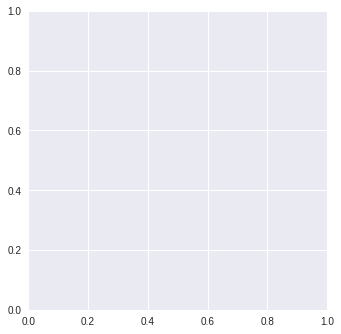

In [0]:
# model = model2
def decodeImg(y):
  '''function to convert a float array into 
     a valid unit8 image '''
  
  # normalizing the input
  y -= y.mean()
  y /= (y.std() + K.epsilon())
  y *= 0.25
  
  # clipping to [0,1]
  y += 0.5
  y = np.clip(y, 0, 1).astype('uint8')
  
  # converting to RGB array
#   y *= 255
#   y = np.clip(y, 0, 255)
  return y

# visualization for convolutional filters

def visualizeFilter(filterNum, imSize=28, epochs=20, alpha=0.1):
  
  layerOutput = model.get_layer(layerName).output
  
  # to maximize the output of the corresponding filter
  loss = K.mean(layerOutput[:,:,:,filterNum])
  
  # computing gradient wrt to each input pixel
  # it is list of tensor so applied the indexing
  gradients = K.gradients(loss, model.input)[0]
  
  # normalizing the gradients
  gradients /= (K.sqrt(K.mean(K.square(gradients))) + K.epsilon())

  loopOver = K.function([model.input], [loss, gradients])
  
#   inpImage = (np.random.random((1, imSize, imSize, 3)) - 0.5) * 20 + 128
  inpImage = np.zeros((1, imSize, imSize, 1))
  
  for _ in range(epochs):
    lossVal, gradVal = loopOver([inpImage])
    inpImage += gradVal * alpha

  # taking in the actual image size
  return decodeImg(inpImage[0]), lossVal

def makeVisualization(filters, n=None):
  '''plot the visualizations of the filters'''
  
  if n is None:
    n = int(np.floor(np.sqrt(len(filters))))
    
  filters.sort(key=lambda x: x[1], reverse=True)
  filters = filters[:n * n]
  
  MARGIN = 3
  width = n * dim + (n - 1) * MARGIN
  height = n * dim + (n - 1) * MARGIN
  
  # making a black image and then paste our visualizations onto that
  allFilters = np.zeros((width, height, 1), dtype='uint8')
  
  # filling the above with our visualizations
  for i in range(n):
    for j in range(n):
      img, _ = filters[i * n + j]
      widthMargin = (dim + MARGIN) * i
      heightMargin = (dim + MARGIN) * j
      
      allFilters[
          widthMargin: widthMargin + dim,
          heightMargin: heightMargin + dim, :] = img
  
#   allFilters[:, :, 0], allFilters[:, :, 2] = allFilters[:, :, 2], allFilters[:, :, 0]
  vis = allFilters
#   vis.save('visualize.png')
#   vis.show()
  plt.imshow(allFilters)
  
layerName = 'conv2d_3'
# inputImg = model.inputs[0]
# print(inputImg.op.type)
# layerDict = dict([(layer.name, layer) for layer in model.layers[1:]])
# outputLayer = layerDict[layerName]
# print(outputLayer.output.shape)

processedFilters = []
for fl in range(model.get_layer(layerName).output.shape[-1]):
  imgLoss = visualizeFilter(fl)
  
  if imgLoss is not None:
    processedFilters.append(imgLoss)

dim = 28
makeVisualization(processedFilters)
    

zs:  (1, 28, 28, 1)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
toy:  1
toy:  (?, 10)
0
Tensor("dense_2/Softmax:0", shape=(?, 10), dtype=float32)
(?,)
(?, 28, 28, 32)
Tensor("Mean_266:0", shape=(32,), dtype=float32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


(1, 28, 28, 1)


<Figure size 576x396 with 0 Axes>

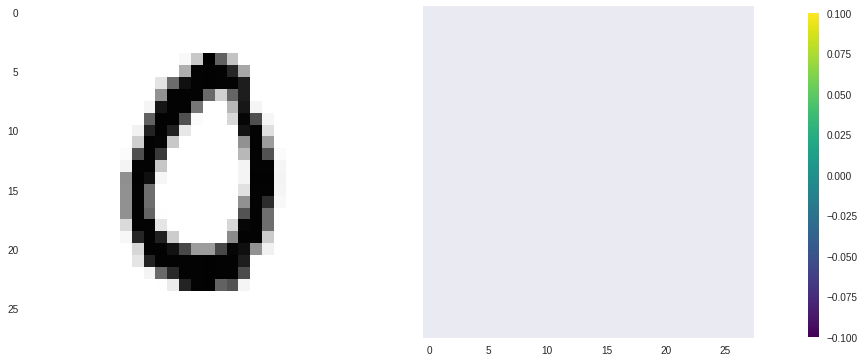

In [0]:
# import matplotlib.pyplot as plt
# imgPath = "/content/classes/0_1_7_0/0_1_7_0_0.jpeg"

# # z is a float32 Numpy array of shape (28, 28, 3)
# z = cv2.imread(imgPath)

# # adding a dimension to transform the array into a batch
# z = np.expand_dims(z, axis=0)
# z = np.array(z, dtype=np.float32)
# z /= 255.0
# print("zs: ",z.shape)
num = 1001
z = np.array([x_test[num]])
print("zs: ",z.shape)
# z = z[0]
preds = model.predict(z)
print(preds)

print("toy: ", len(model.outputs))
print("toy: ", (model.outputs[0].shape))
print(y_test[num])

print(model.output)
# pass the class here
lineOutput = model.output[:,int(y_test[num])]
print(lineOutput.shape)
print(model.get_layer(layerName).output.shape)
# gradient of one of the output class wrt to the output feature map of the given layer
grads = K.gradients(lineOutput, model.get_layer(layerName).output)[0]

# print(grads.shape)

# return the mean intensity of the gradient over a specific feature map channel
pooledGrads = K.mean(grads, axis=(0,1,2))

print(pooledGrads)

# below function allows to access the values of pooledGrads and the output feature map
# given a image
iterate = K.function([model.input], [pooledGrads, model.get_layer(layerName).output[0]])

# get the value for the given input
pooledValue, convOutput = iterate([z])

# print(pooledValue)

# multiplying each channel(filter) in the feature map array by 'how
# important the channel is with reagrd to given class'
for i in range(model.get_layer(layerName).output.shape[-1]):
  convOutput[:, :, i] *= pooledValue[i]
  
# channel wise mean of the resulting feature map
heatmap = np.mean(convOutput, axis=-1)

# for visualization normalizing the value b/w 0 and 1
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(15,15))
# plt.grid(False)
ax[1].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].grid(False)
ax[0].grid(False)

print(z.shape)
im = ax[1].imshow(heatmap, cmap="viridis")
ax[0].imshow(z.squeeze())
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax, aspect=10)

plt.savefig("hx.png")
# plt.show(heatmap)

In [0]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_test[119].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    size = activations[0].shape[1]
    scale = 1. / size
    activation = activations[act_index]
    activation_index=0
    plt.figure()
    
    fig, ax = plt.subplots(row_size, col_size, figsize=(24,10))
    fig.suptitle('Activation Map', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].grid(False)
            ax[row][col].set_yticklabels([])
            ax[row][col].set_xticklabels([])

            im = ax[row][col].imshow(activation[0, :, :, activation_index], cmap='viridis', aspect='auto')
            activation_index += 1
#     plt.colorbar()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.10, 0.01, 0.8])
    fig.colorbar(im, cax=cbar_ax, aspect=10)

    plt.savefig('abc.png')
# activations.shape

In [0]:
# plt.imshow(x_train[10].reshape(28,28))
# print(x_train[10].shape)
# activations[0].shape
# a=activations[0].reshape(28,28,32)

In [0]:

# plt.imshow(a[:,:,5])

(1, 28, 28, 32)


<Figure size 576x396 with 0 Axes>

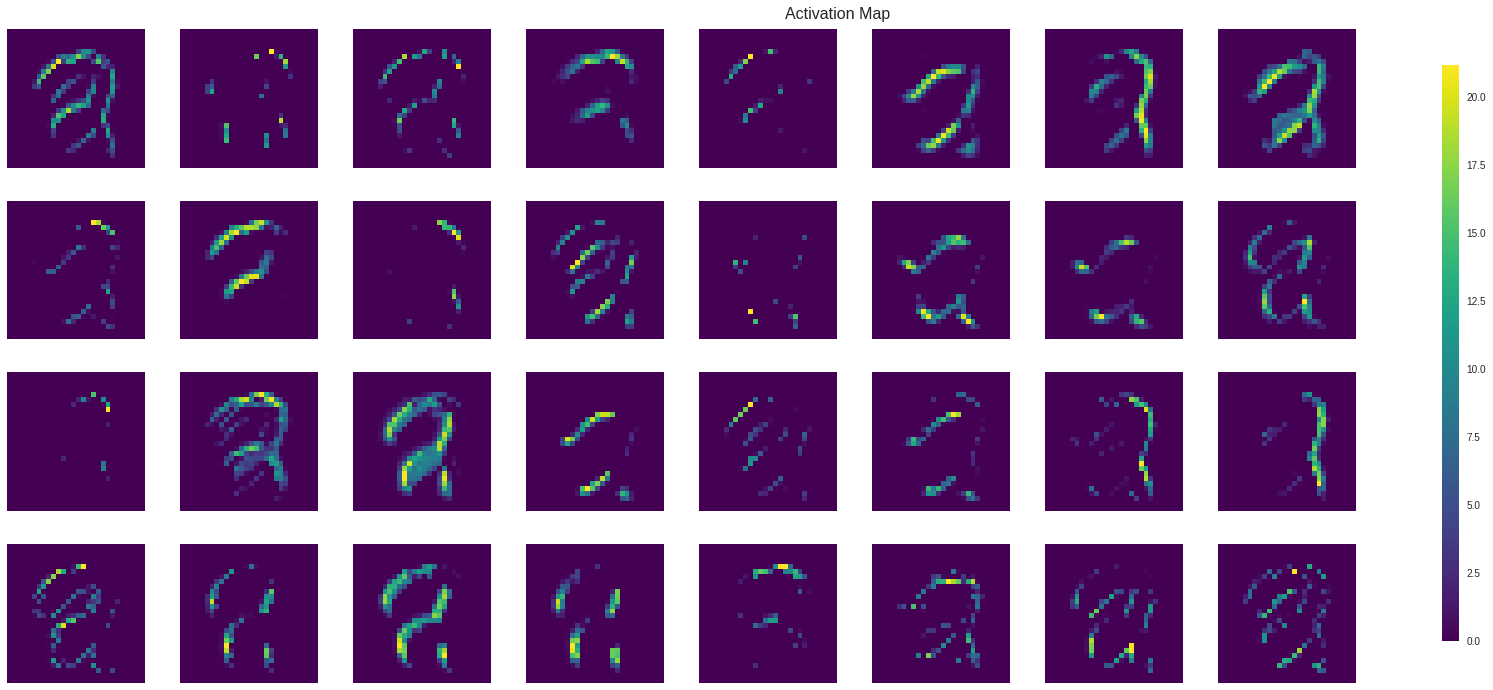

In [0]:
print(activations[0].shape)
display_activation(activations, 8, 4 ,0 )
# display_activation(activations, 4, 8 ,1 )
# display_activation(activations, 4, 8 ,2 )